### Introduction
### Create a model that can accurately predict whether a user belongs to the HCP(Healthcare Professional) category and its specialization id/taxonomy based on ad server logs information.

### Import the necessary packages.

In [64]:
!pip install wordcloud

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # visualization
from matplotlib import pyplot as plt # visualization
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import missingno as msno
import re
import copy
import random

from scipy.stats import skew, kurtosis
from prettytable import PrettyTable


import nltk

from nltk.corpus import stopwords
from collections import defaultdict
from collections import Counter


from wordcloud import WordCloud, STOPWORDS
stopwords=set(STOPWORDS)


### Import train and test dataset

In [3]:
train=pd.read_csv("E:\hcp\HCP_Train.csv", encoding='ISO-8859-1')
test=pd.read_csv("E:\hcp\HCP_Test.csv", encoding='ISO-8859-1')
                                  

### Change column names to lowercase.

In [67]:
def colnamefix(df):
    df=df.rename(columns={col:col.lower() for col in df.columns})
    return df

In [68]:
train=colnamefix(train)

### Structure of the train and test dataset.

In [69]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113937 entries, 0 to 113936
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               113937 non-null  int64  
 1   devicetype       113937 non-null  object 
 2   platform_id      113937 non-null  int64  
 3   bidrequestip     113937 non-null  object 
 4   userplatformuid  113933 non-null  object 
 5   usercity         107578 non-null  object 
 6   userzipcode      109345 non-null  float64
 7   useragent        113935 non-null  object 
 8   platformtype     113937 non-null  object 
 9   channeltype      113937 non-null  object 
 10  url              113937 non-null  object 
 11  keywords         113937 non-null  object 
 12  taxonomy         32313 non-null   object 
 13  is_hcp           113936 non-null  float64
dtypes: float64(2), int64(2), object(10)
memory usage: 12.2+ MB


#### The above information shows that there are 113937 data entries and 14 columns.

#### The above information shows that there are 28493 data entries and 12 columns.

### Let's see is there any missing values in train and test dataset by column wise.

In [70]:
train.isnull().sum()

id                     0
devicetype             0
platform_id            0
bidrequestip           0
userplatformuid        4
usercity            6359
userzipcode         4592
useragent              2
platformtype           0
channeltype            0
url                    0
keywords               0
taxonomy           81624
is_hcp                 1
dtype: int64

#### The above information shows that there are missing values in the columns usercity, userzipcode, and taxonomy.

In [71]:
test.isnull().sum()

ID                    0
DEVICETYPE            0
PLATFORM_ID           0
BIDREQUESTIP          0
USERPLATFORMUID       0
USERCITY           1559
USERZIPCODE        1115
USERAGENT             1
PLATFORMTYPE          0
CHANNELTYPE           0
URL                   0
KEYWORDS              0
dtype: int64

#### The above information shows that there are missing values in the columns usercity and userzipcode.

In [72]:
train['is_hcp'].value_counts()

0.0    79756
1.0    34180
Name: is_hcp, dtype: int64

### Let's see the glimpse of train dataset

In [73]:
train.head(2)

,id,devicetype,platform_id,bidrequestip,userplatformuid,usercity,userzipcode,useragent,platformtype,channeltype,url,keywords,taxonomy,is_hcp
0,1001,Desktop,2,170.173.0.22,6974dcaa-f932-480e-9fb5-c52e20e1393a,Portland,97206.0,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,Online Medical Journal,Website,https://www.cancertherapyadvisor.com/home/canc...,General|Endocrine|False|Medicine|Surgery|Urolo...,NaN,0.0
1,1002,Desktop,2,65.216.253.25,c12f3f8f-8fcf-484a-90e1-1ac04db8cdcf,Arlington,22202.0,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,Online Medical Journal,Website,https://www.cancertherapyadvisor.com/home/deci...,Bone Marrow|Radiography|Chronic|Oncology|Psych...,NaN,0.0


### Let's explore the target columns distribution

In [74]:
train['is_hcp']=train['is_hcp'].map({1:'yes',0:'no'})

In [75]:
def count_plot(df,col,hue=None,title='',size=(6,6),r=None,switch=False):
    _=plt.figure(figsize=size)
    if switch:
        _=sns.countplot(y=df[col],order=df[col].value_counts().index,hue=hue)
        _=plt.title(f"{title}",fontsize=14)
        _=plt.ylabel(col,fontsize=12)
        _=plt.yticks(fontsize=12,rotation=r)
    else:
        _=sns.countplot(x=df[col],order=df[col].value_counts().index,hue=hue)
        _=plt.title(f"{title}",fontsize=14)
        _=plt.xlabel(col,fontsize=12)
        _=plt.xticks(fontsize=12,rotation=r)

In [76]:
def group_by_count_perc(df,grp,val):
    df=df.groupby(grp)[val].agg({'count'}).reset_index().assign(perc= lambda x: round(x['count'] / x['count'].sum() * 100,2))
    df['perc']=df['perc'].apply(lambda x:str(x)+"%")
    return df

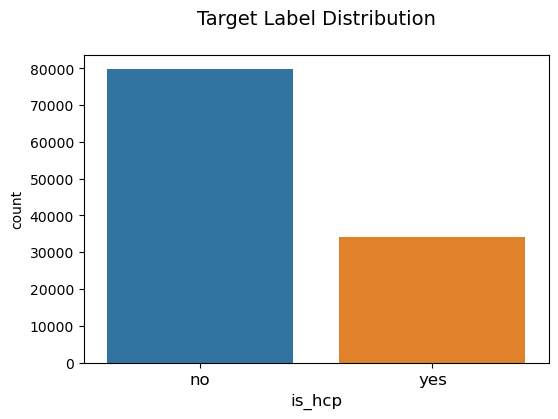

In [77]:
count_plot(train,'is_hcp',size=(6,4),title='Target Label Distribution\n')

In [78]:
group_by_count_perc(train,'is_hcp','is_hcp')

,is_hcp,count,perc
0,no,79756,70.0%
1,yes,34180,30.0%


In [79]:
train.shape[0]

113937

#### The above plot and summary explains that the target label is imabalanced.
#### In 113937 users,70% of users(79756) were not a healthcare professionals.
#### In 113937 users,30% of users(34180) were not a healthcare professionals. 

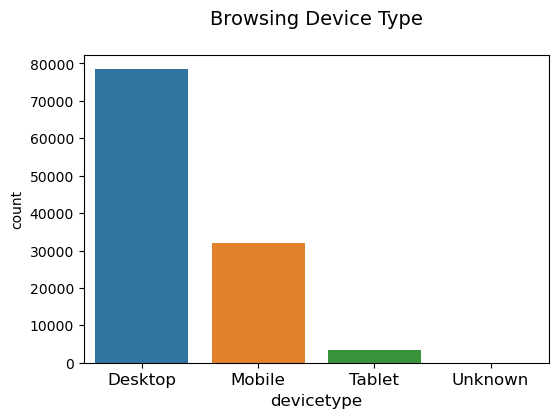

In [80]:
count_plot(df=train,col='devicetype',size=(6,4),title='Browsing Device Type\n')

In [81]:
train['devicetype'].value_counts()

Desktop    78423
Mobile     32065
Tablet      3425
Unknown       24
Name: devicetype, dtype: int64

#### The above plot and summary explains that most of the users used desktop device for browsing.

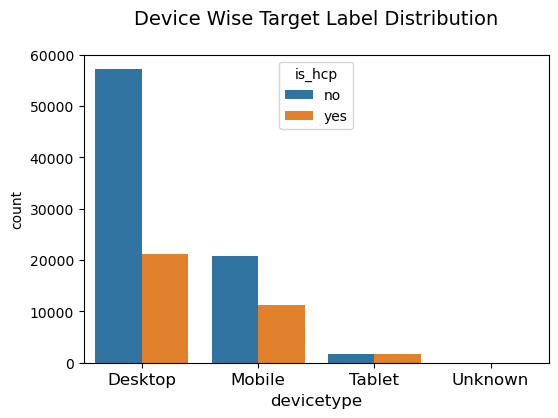

In [82]:
count_plot(df=train,col='devicetype',hue=train['is_hcp'],size=(6,4),title='Device Wise Target Label Distribution\n')

In [83]:
group_by_count_perc(train,grp=['devicetype','is_hcp'],val='is_hcp')

,devicetype,is_hcp,count,perc
0,Desktop,no,57161,50.17%
1,Desktop,yes,21262,18.66%
2,Mobile,no,20796,18.25%
3,Mobile,yes,11268,9.89%
4,Tablet,no,1775,1.56%
5,Tablet,yes,1650,1.45%
6,Unknown,no,24,0.02%


#### The above plot and summary explains that the most of health care professionals were used desktop device for browsing.

### Let's see various platform used by the user.

In [84]:
train['platform_id'].nunique()

15

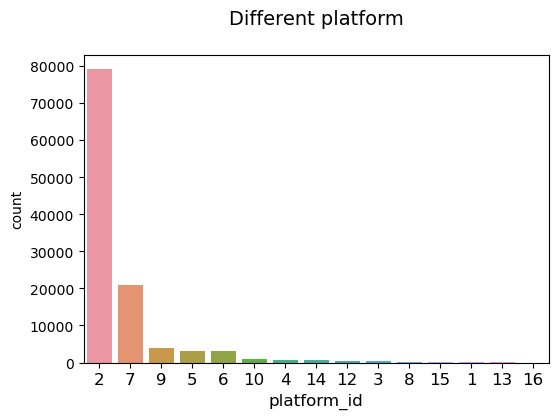

In [85]:
count_plot(train,'platform_id',size=(6,4),title="Different platform\n")

In [86]:
group_by_count_perc(train,['platform_id'],'platform_id')

,platform_id,count,perc
0,1,40,0.04%
1,2,79151,69.47%
2,3,479,0.42%
3,4,745,0.65%
4,5,3230,2.83%
5,6,2978,2.61%
6,7,20913,18.35%
7,8,130,0.11%
8,9,3891,3.42%
9,10,1037,0.91%


#### The above plot and summary explains that most of users were used platform 7 and 2.

### Let's see platform wise target label distribution,

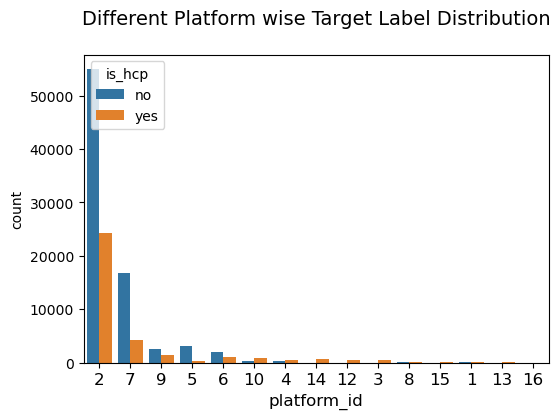

In [87]:
count_plot(train,'platform_id',hue=train['is_hcp'],size=(6,4),title="Different Platform wise Target Label Distribution\n")

In [88]:
group_by_count_perc(train,['platform_id','is_hcp'],'is_hcp')

,platform_id,is_hcp,count,perc
0,1,no,31,0.03%
1,1,yes,9,0.01%
2,2,no,54939,48.22%
3,2,yes,24212,21.25%
4,3,yes,479,0.42%
5,4,no,245,0.22%
6,4,yes,500,0.44%
7,5,no,3014,2.65%
8,5,yes,216,0.19%
9,6,no,2032,1.78%


#### The above plot and summary explains that most of the healthcare professionals used platform 2 and 7.
#### The users who have used the platform 1 to 10 are either the healthcare professionals or normal user.
#### The users who have used the platform 12 to 15 are only the healthcare professionals.

### Let's see the target label distribution by users device type and platform. 

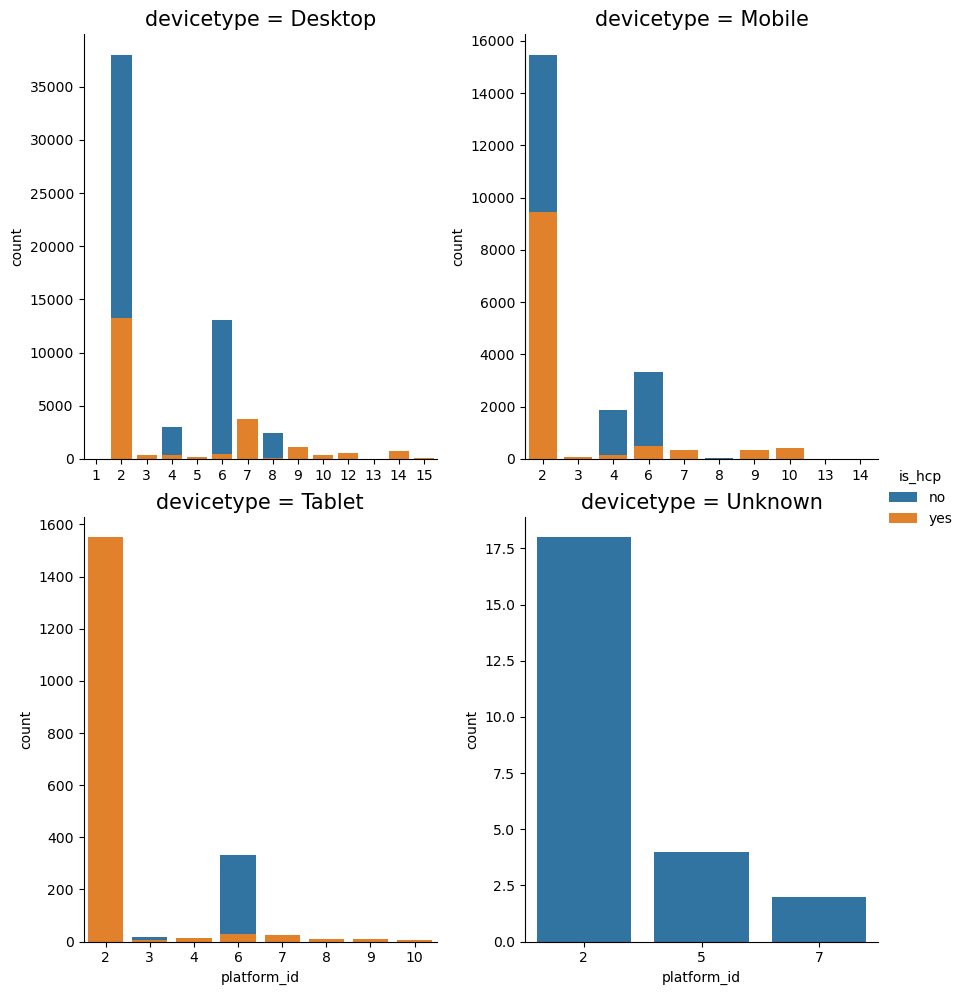

In [89]:
dev_plat_target = sns.FacetGrid(data=train,col_wrap=2,hue='is_hcp',legend_out=True,
        col="devicetype",margin_titles=True,height=5,aspect=.9,sharex=False,sharey=False)
dev_plat_target.map_dataframe(sns.countplot, x='platform_id',)
dev_plat_target.set_titles(size=15)
dev_plat_target.add_legend()


In [90]:
group_by_count_perc(train,['devicetype','platform_id','is_hcp'],'is_hcp')

,devicetype,platform_id,is_hcp,count,perc
0,Desktop,1,no,31,0.03%
1,Desktop,1,yes,9,0.01%
2,Desktop,2,no,38036,33.38%
3,Desktop,2,yes,13216,11.6%
4,Desktop,3,yes,400,0.35%
5,Desktop,4,no,243,0.21%
6,Desktop,4,yes,326,0.29%
7,Desktop,5,no,2993,2.63%
8,Desktop,5,yes,216,0.19%
9,Desktop,6,no,167,0.15%


#### The above plot and summary explain that the desktop user used platform 1 to platform 16.
#### The mobile user used platforms 2 to 14.
#### The tablet user used platforms 2  to 10. In that, users who have used platforms 5 and 6 are normal users. Platforms 8 to 10 are used by only healthcare professionals.
#### Normal users only used platforms 2, 5, and 7 from unknown devices.

### Let's see number of unique ip address(request origin).

In [91]:
train['bidrequestip'].nunique()

33664

#### There are 33664 unique ip address.

#### Let's see which ip address has maximum users.

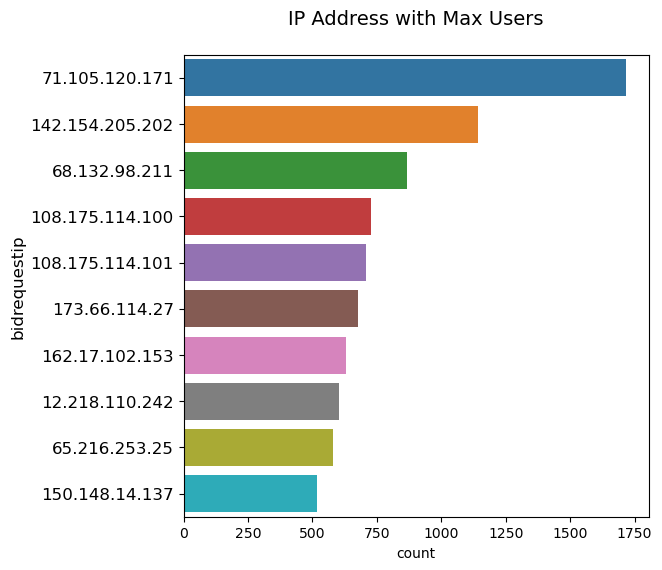

In [92]:
count_plot(train[train['bidrequestip'].isin(train.groupby('bidrequestip')['id'].agg({'count'}).reset_index().nlargest(10,'count')['bidrequestip'].values)],
                 'bidrequestip',switch=True,title="IP Address with Max Users\n")

In [93]:
train.groupby('bidrequestip')['id'].agg({'count'}).reset_index().nlargest(10,'count')

,bidrequestip,count
23549,71.105.120.171,1718
4432,142.154.205.202,1143
21165,68.132.98.211,866
2344,108.175.114.100,727
2345,108.175.114.101,707
9176,173.66.114.27,675
5521,162.17.102.153,629
3343,12.218.110.242,604
19253,65.216.253.25,581
4808,150.148.14.137,517


### Let's see which device and platform were used by the IP address which has more users.

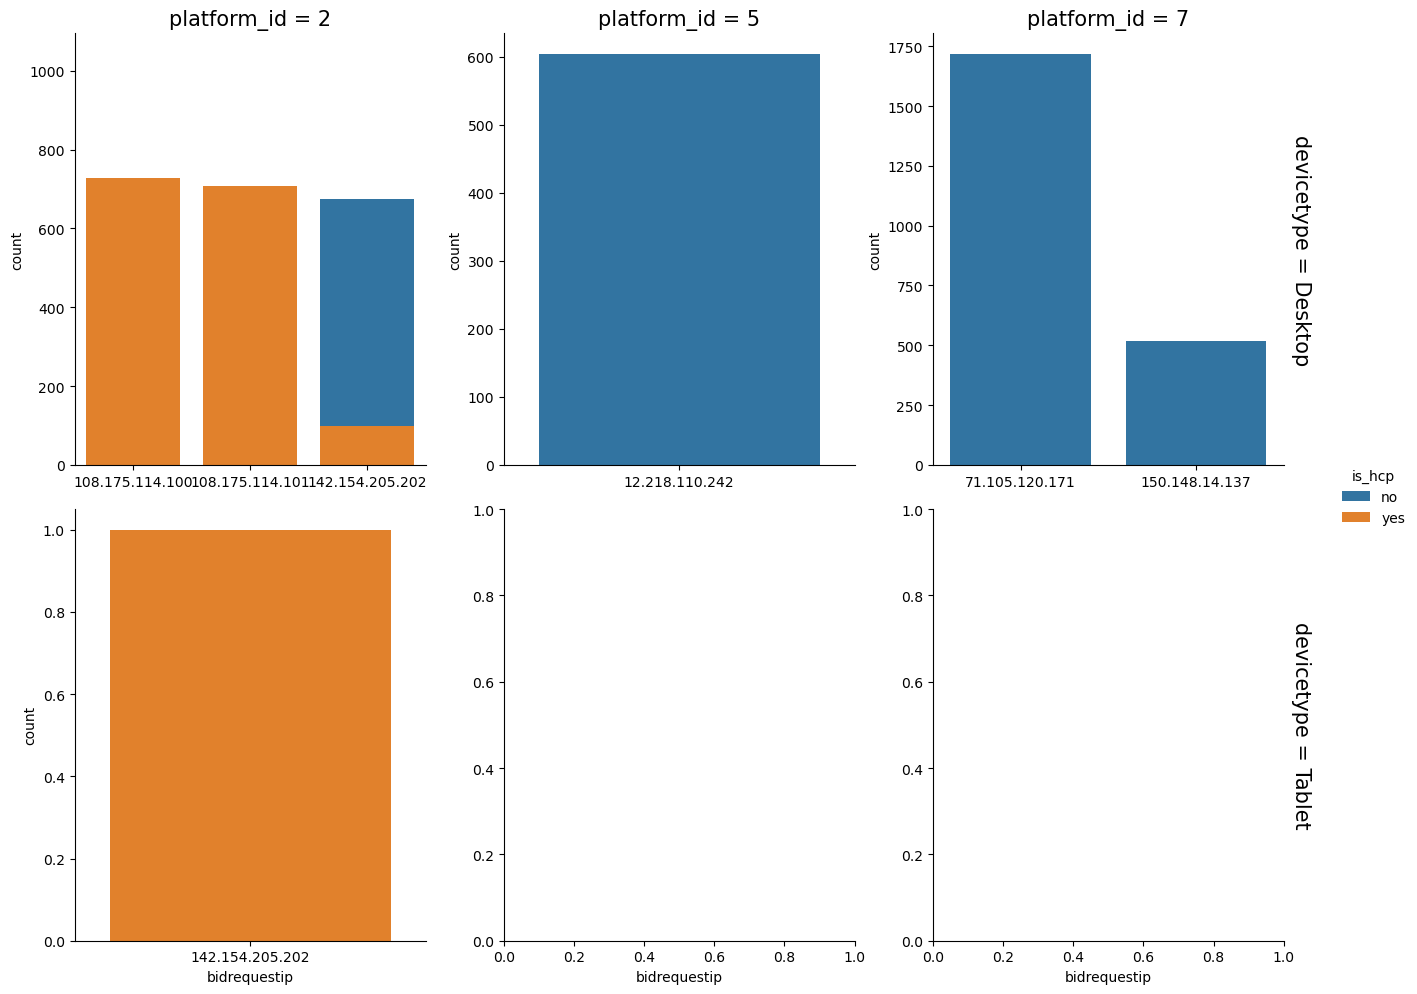

In [94]:
dev_plat_id= sns.FacetGrid(data=train[train['bidrequestip'].isin(train.groupby('bidrequestip')['id'].agg({'count'}).reset_index().nlargest(10,'count')['bidrequestip'].values)],
                           hue='is_hcp',legend_out=True,row='devicetype',
        col="platform_id",margin_titles=True,height=5,aspect=.9,sharex=False,sharey=False)
dev_plat_id.map_dataframe(sns.countplot, x='bidrequestip',)
dev_plat_id.set_titles(size=15)
dev_plat_id.add_legend()


#### The above plot explains that the most used devices were mobile and desktop. The most used platforms were 2, 5, and 7.

### Let's see number of unique platform user id

In [95]:
train['userplatformuid'].nunique()

53780

#### There are 53780 unique platform user id.

#### Let's see which platform maximum users.

In [96]:
train.groupby('platform_id')['userplatformuid'].agg({'count'}).reset_index().sort_values("count",ascending=False)

,platform_id,count
1,2,79149
6,7,20911
8,9,3891
4,5,3230
5,6,2978
9,10,1037
3,4,745
12,14,725
10,12,544
2,3,479


#### Platform 2 has more users.

In [97]:
train.groupby('platform_id')['userplatformuid'].agg({'count'}).reset_index()

,platform_id,count
0,1,40
1,2,79149
2,3,479
3,4,745
4,5,3230
5,6,2978
6,7,20911
7,8,130
8,9,3891
9,10,1037


### Let's see various users city

In [98]:
train['usercity'].nunique()

4420

#### There are 4420 cities.

### Let's which city has maximum users.

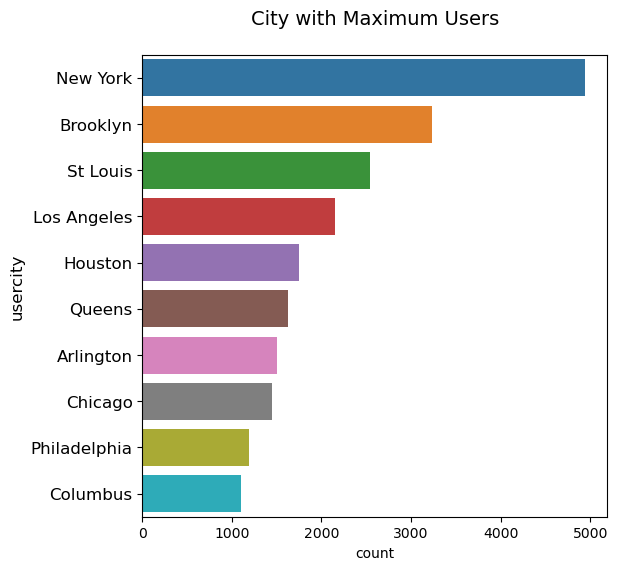

In [99]:
count_plot(train[train['usercity'].isin(train.groupby('usercity')['id'].agg({'count'}).reset_index().nlargest(10,'count')['usercity'].values)],
          'usercity',title='City with Maximum Users\n',switch=True)

In [100]:
train.groupby('usercity')['id'].agg({'count'}).reset_index().nlargest(10,'count')

,usercity,count
2718,New York,4943
464,Brooklyn,3237
3756,St Louis,2545
2212,Los Angeles,2154
1767,Houston,1747
3232,Queens,1629
130,Arlington,1503
687,Chicago,1448
3067,Philadelphia,1191
792,Columbus,1105


#### The above plot and summary explain that the more users were from New York city.

### Let's see which city has maximum healthcare professionals. 

In [101]:
group_by_count_perc(train,['usercity','is_hcp'],'is_hcp').nlargest(20,'count').query('is_hcp=="yes"')


,usercity,is_hcp,count,perc
4081,New York,yes,2391,2.22%
1199,Columbus,yes,639,0.59%
5230,San Francisco,yes,573,0.53%


#### Higher number of healthcare professional from New York.

### Let's see which city has max normal users.

In [102]:
group_by_count_perc(train,['usercity','is_hcp'],'is_hcp').nlargest(10,'count').query('is_hcp=="no"')


,usercity,is_hcp,count,perc
701,Brooklyn,no,2963,2.75%
4080,New York,no,2552,2.37%
5640,St Louis,no,2396,2.23%
3319,Los Angeles,no,1832,1.7%
198,Arlington,no,1439,1.34%
2645,Houston,no,1425,1.32%
4853,Queens,no,1395,1.3%
1040,Chicago,no,1065,0.99%
1428,Deer Park,no,882,0.82%


#### Brooklyn, New York, and St Louis cities have maximum normal users.

### Lets's see number of unique user zipcode.

In [103]:
train['userzipcode'].nunique()

11278

#### There are 11278 unique zipcode from 4420 cities.

### Let's see maximum zipcode by cities.

In [104]:
group_by_count_perc(train,['usercity','userzipcode'],'userzipcode').nlargest(10,'count')


,usercity,userzipcode,count,perc
9269,St Louis,63169.0,2116,1.97%
1164,Brooklyn,11226.0,1752,1.63%
309,Arlington,22202.0,1259,1.17%
6514,New York,10001.0,1190,1.11%
5335,Los Angeles,90060.0,1058,0.98%
6526,New York,10016.0,925,0.86%
2418,Deer Park,11729.0,874,0.81%
6521,New York,10010.0,720,0.67%
1142,Brooklyn,11204.0,657,0.61%
7167,Palm Beach Gardens,33418.0,651,0.61%


#### St Louis city zip code 63169 has maximum users.

### Let's see from which zip code area the maximum healthcare professionals are.

In [105]:
group_by_count_perc(train,['usercity','userzipcode','is_hcp'],'is_hcp').nlargest(10,'count').query('is_hcp=="yes"')


,usercity,userzipcode,is_hcp,count,perc
9142,New York,10016.0,yes,859,0.8%
9133,New York,10010.0,yes,669,0.62%


#### The maximum number of healthcare professionals are from the city of New York and zip code-10016.

### Let's see what type of operating system and browser were used by users.

#### Let's extract device information from useragent

In [106]:
train['device_info']=train['useragent'].str.extract("([a-z|A-Z|0-9|\s|.|,]+;)")
train['device_info']=train['device_info'].str.replace(";","")

### Let's see Most used Devices 

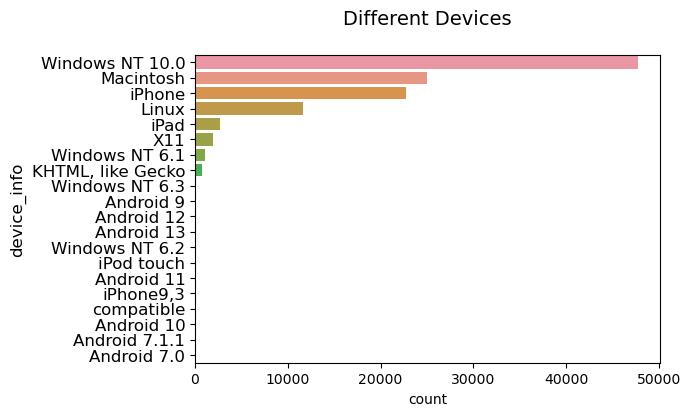

In [107]:
count_plot(train,'device_info',title='Different Devices\n',switch=True,size=(6,4))

#### The above plot explains that the most used devices in the desktop category are Windows NT 10.0 and Macintosh. In the mobile category iPhone.

### Let's see Different devices wise target label distribution.

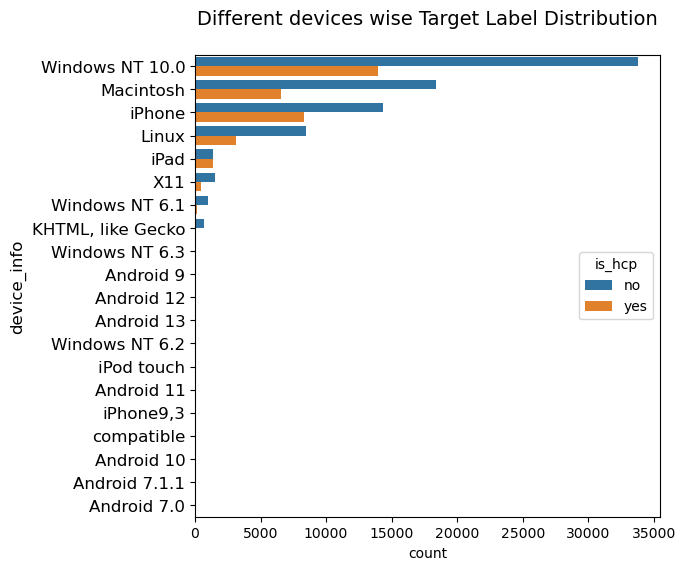

In [108]:
count_plot(train,'device_info',hue=train['is_hcp'],
           title="Different devices wise Target Label Distribution\n",
          switch=True)

In [109]:
group_by_count_perc(train,['device_info','is_hcp'],'is_hcp')

,device_info,is_hcp,count,perc
0,Android 10,no,1,0.0%
1,Android 10,yes,1,0.0%
2,Android 11,no,1,0.0%
3,Android 11,yes,2,0.0%
4,Android 12,no,22,0.02%
5,Android 12,yes,15,0.01%
6,Android 13,no,28,0.02%
7,Android 13,yes,2,0.0%
8,Android 7.0,yes,1,0.0%
9,Android 7.1.1,no,1,0.0%


#### The above plot explains that when compared to Microsoft, the maximum number of healthcare professionals used Apple devices.

#### Let's extract browser information from useragent

In [110]:
train['browser']=train['useragent'].apply(lambda x:"_".join(re.findall("(Mozilla|Chrome|Safari)",str(x))))

### Let's see Most used browser

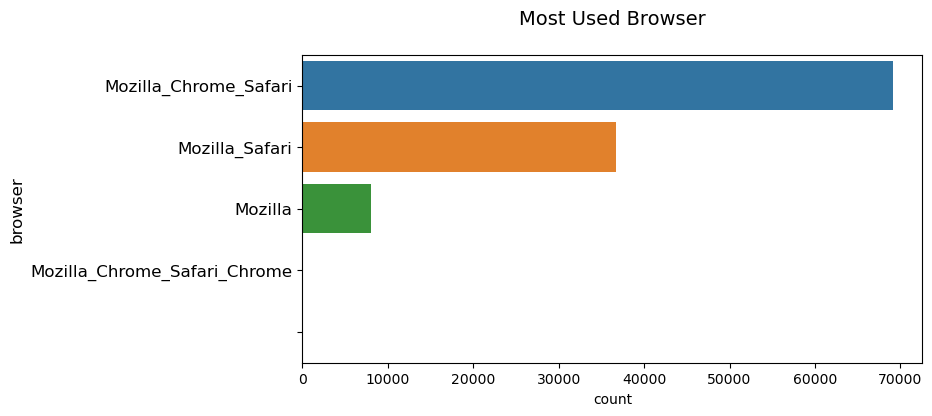

In [111]:
count_plot(train,'browser',title="Most Used Browser\n",switch=True,size=(8,4))

#### The most used browser on both microsoft and windows was mozilla.

### Let's see Different browser wise target label distribution.

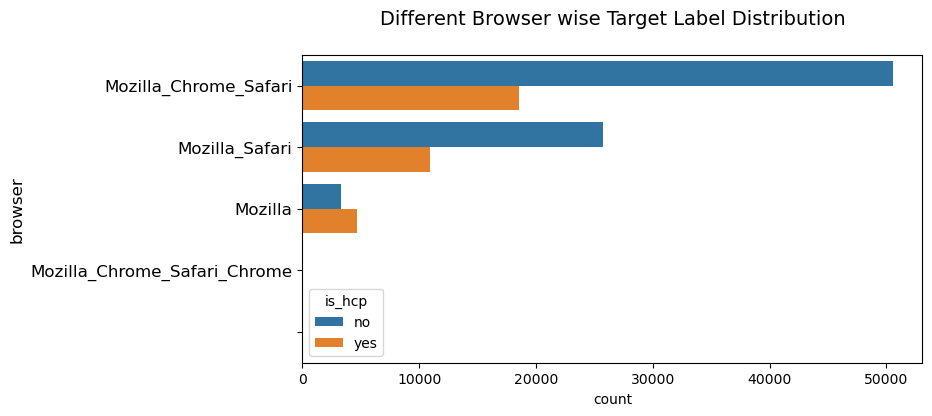

In [112]:
count_plot(train,'browser',hue=train['is_hcp'],
           title="Different Browser wise Target Label Distribution\n",
          switch=True,size=(8,4))

### Let's see various platform type.

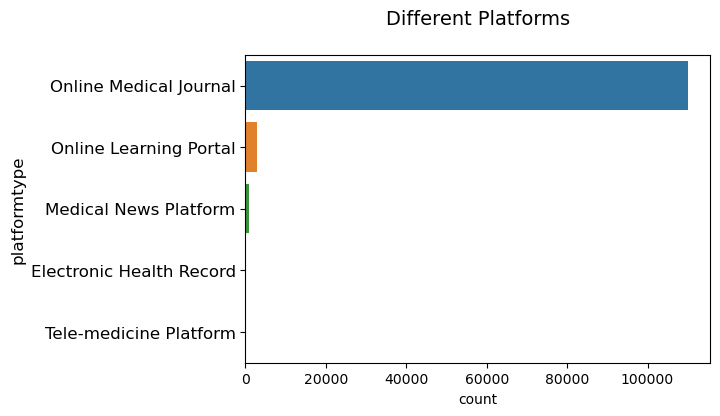

In [113]:
count_plot(train,"platformtype",title="Different Platforms\n",switch=True,size=(6,4))

In [114]:
group_by_count_perc(train,'platformtype','platformtype')

,platformtype,count,perc
0,Electronic Health Record,40,0.04%
1,Medical News Platform,798,0.7%
2,Online Learning Portal,2978,2.61%
3,Online Medical Journal,110120,96.65%
4,Tele-medicine Platform,1,0.0%


#### 96% of user used online medical journal platform for browsing.

### Let's see platform type wise target label distribution

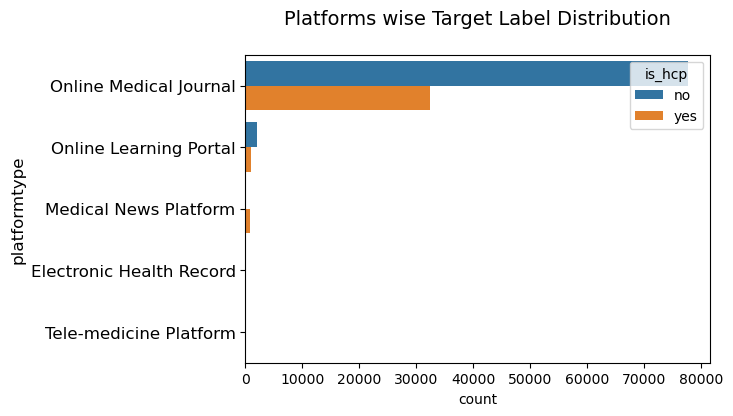

In [115]:
count_plot(train,"platformtype",hue=train['is_hcp'],title="Platforms wise Target Label Distribution\n",switch=True,size=(6,4))

In [116]:
group_by_count_perc(train,['platformtype','is_hcp'],'is_hcp')

,platformtype,is_hcp,count,perc
0,Electronic Health Record,no,31,0.03%
1,Electronic Health Record,yes,9,0.01%
2,Medical News Platform,yes,798,0.7%
3,Online Learning Portal,no,2032,1.78%
4,Online Learning Portal,yes,946,0.83%
5,Online Medical Journal,no,77692,68.19%
6,Online Medical Journal,yes,32427,28.46%
7,Tele-medicine Platform,no,1,0.0%


#### If the user used the medical news platform on browsing then the user would be a healthcare professional. If used telemedicine platform then the user would be the normal user. 

#### If the user has not used medical news platform and telemedicine platform then the user would be either a healthcare professional or a normal user. 

### Let's see which sites are frequently visited by the users.

#### Let's extract site information from the url.

In [117]:
train['site_name']=train['url'].str.extract("https?://(www.|consumer.|.uat)?(\w+)(.com|.org)?")[1]

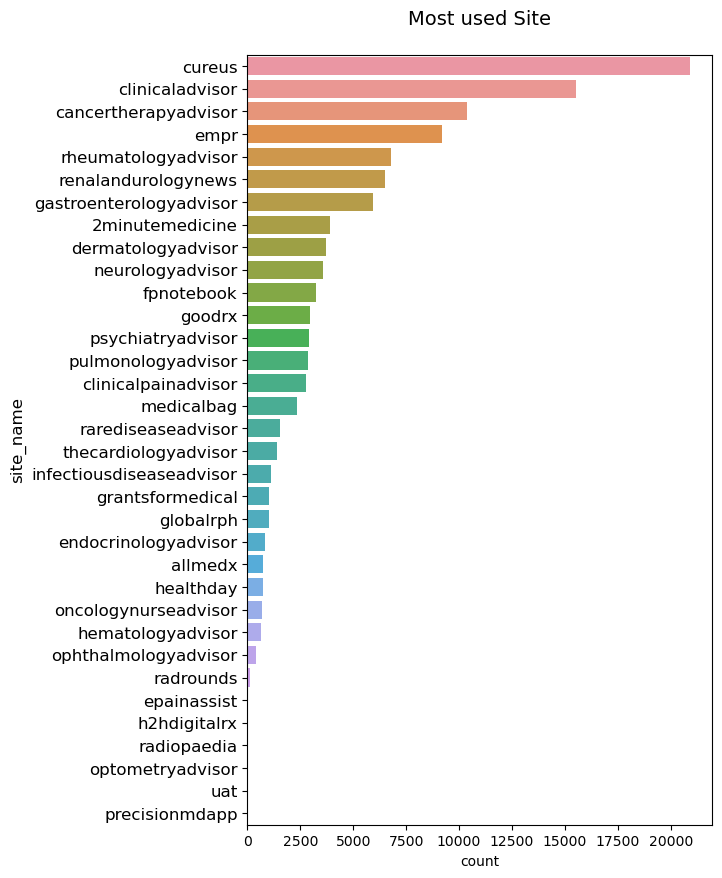

In [118]:
count_plot(train,'site_name',size=(6,10),title="Most used Site\n",switch=True)

In [119]:
group_by_count_perc(train,'site_name','site_name')

,site_name,count,perc
0,2minutemedicine,3891,3.42%
1,allmedx,745,0.65%
2,cancertherapyadvisor,10381,9.11%
3,clinicaladvisor,15529,13.63%
4,clinicalpainadvisor,2751,2.41%
5,cureus,20913,18.35%
6,dermatologyadvisor,3705,3.25%
7,empr,9182,8.06%
8,endocrinologyadvisor,846,0.74%
9,epainassist,42,0.04%


#### The above plot and summary explains that maximum users used the sites cureus, clinicaladvisor, and cancertherapyadvisor.

#### Let's see the target label distribution of different sites.

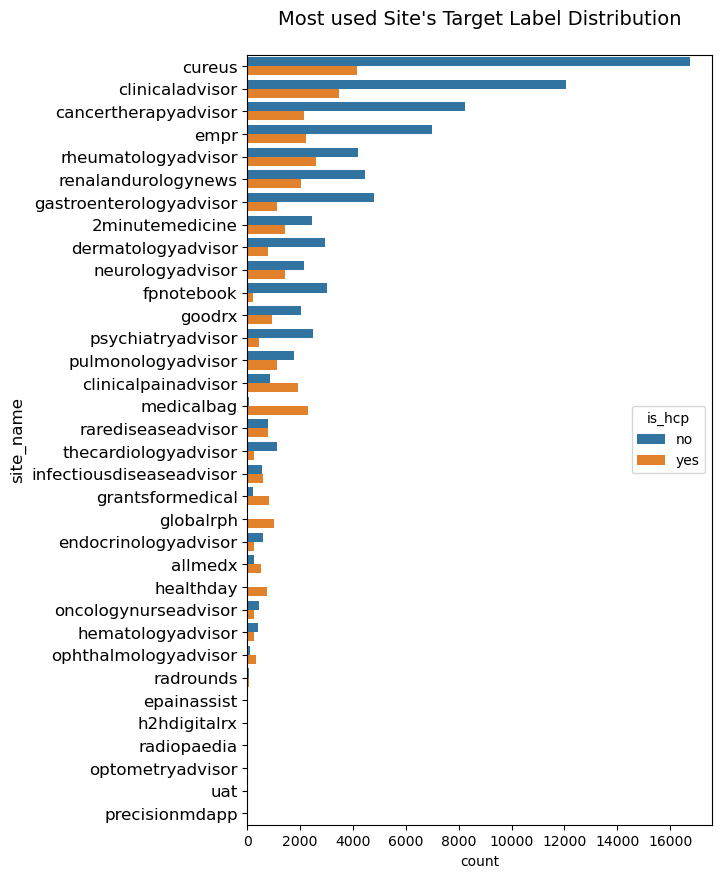

In [120]:
count_plot(train,'site_name',hue=train['is_hcp'],
           size=(6,10),title="Most used Site's Target Label Distribution\n",switch=True)

In [121]:
group_by_count_perc(train,['site_name','is_hcp'],'is_hcp').pivot(index='site_name', columns='is_hcp', values='count').reset_index()

is_hcp,site_name,no,yes
0,2minutemedicine,2453.0,1437.0
1,allmedx,245.0,500.0
2,cancertherapyadvisor,8226.0,2155.0
3,clinicaladvisor,12054.0,3475.0
4,clinicalpainadvisor,847.0,1904.0
5,cureus,16758.0,4155.0
6,dermatologyadvisor,2935.0,770.0
7,empr,6980.0,2202.0
8,endocrinologyadvisor,578.0,268.0
9,epainassist,NaN,42.0


#### The following sites were only used by healthcare professionals.

In [122]:
group_by_count_perc(train,['site_name','is_hcp'],'is_hcp').pivot(index='site_name', columns='is_hcp', values='count').reset_index().query("no.isnull()")

is_hcp,site_name,no,yes
9,epainassist,NaN,42.0
12,globalrph,NaN,1023.0
16,healthday,NaN,725.0
27,radiopaedia,NaN,31.0
33,uat,NaN,8.0


#### The following sites were only used by either healthcare professionals or normal users.

In [123]:
group_by_count_perc(train,['site_name','is_hcp'],'is_hcp').pivot(index='site_name', columns='is_hcp', values='count').reset_index().query("no.notnull() and yes.notnull()")

is_hcp,site_name,no,yes
0,2minutemedicine,2453.0,1437.0
1,allmedx,245.0,500.0
2,cancertherapyadvisor,8226.0,2155.0
3,clinicaladvisor,12054.0,3475.0
4,clinicalpainadvisor,847.0,1904.0
5,cureus,16758.0,4155.0
6,dermatologyadvisor,2935.0,770.0
7,empr,6980.0,2202.0
8,endocrinologyadvisor,578.0,268.0
10,fpnotebook,3014.0,216.0


#### Let's see what was searched on the site by the user.

In [124]:
train['search_info']=train['url'].str.extract("https?://(www.|consumer.|.uat)?(\w+)(.com|.org)?(.+)")[3]
train['search_info']=train['search_info'].str.replace("[^\w\s]|home|articles|topics|slang|code|words|[0-9]|[…\u2026]+"," ")
train['search_info']=train['search_info'].apply(lambda x:x.strip())

### Let's see the most frequent words on user's search by target label.

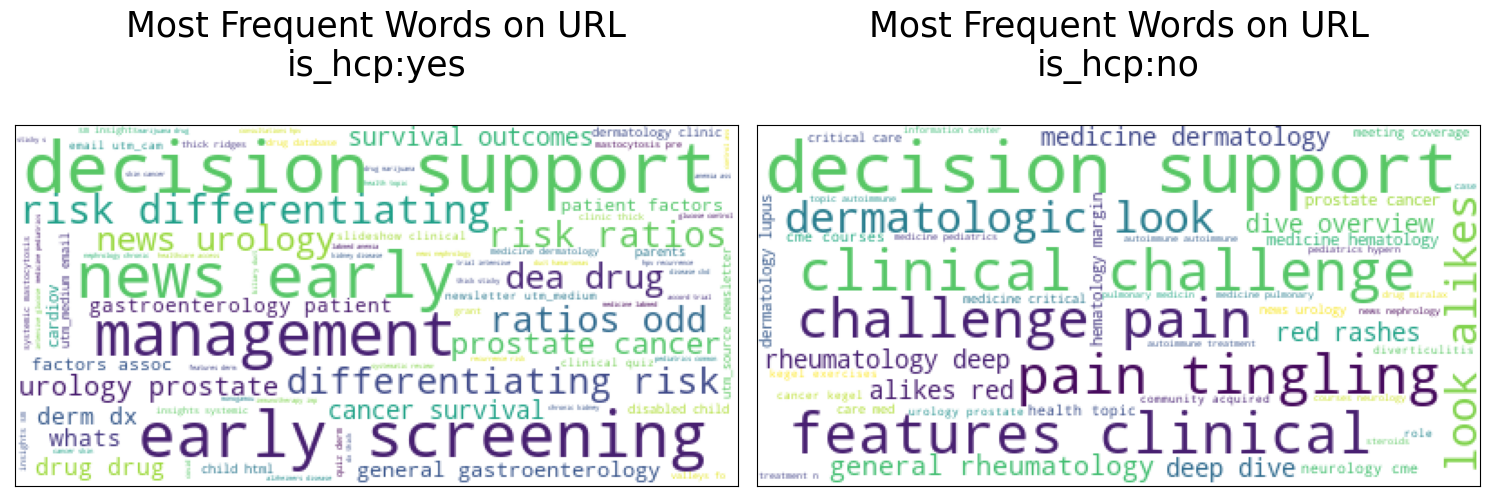

In [125]:
fig=plt.subplots(figsize=(15, 15))
for i,label in enumerate(['yes','no']):    
    _=plt.subplot(1,2,i+1)
    wc = WordCloud(background_color="white", max_words=100, stopwords=stopwords,
                max_font_size=40, random_state=42).generate(train[train['is_hcp']==label]['search_info'].to_string())
    plt.imshow(wc)
    plt.title(f"Most Frequent Words on URL\nis_hcp:{label}\n",fontsize=25)
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()

### Let's see what keywords appeared on the URL by target label.

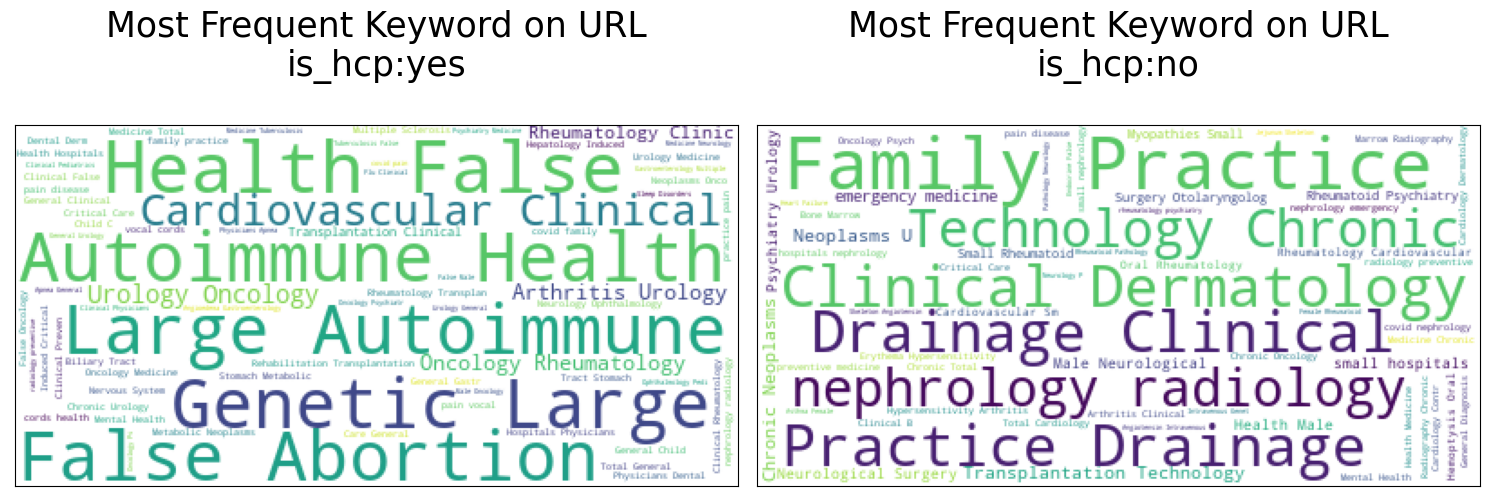

In [126]:
fig=plt.subplots(figsize=(15, 15))
for i,label in enumerate(['yes','no']):    
    _=plt.subplot(1,2,i+1)
    wc = WordCloud(background_color="white", max_words=100, stopwords=stopwords,
                max_font_size=40, random_state=42).generate(train[train['is_hcp']==label]['keywords'].to_string())
    plt.imshow(wc)
    plt.title(f"Most Frequent Keyword on URL\nis_hcp:{label}\n",fontsize=25)
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()